Epoch 1: Train Acc = 7.17%, Val Acc = 13.91%
Epoch 2: Train Acc = 16.96%, Val Acc = 31.13%
Epoch 3: Train Acc = 40.07%, Val Acc = 48.34%
Epoch 4: Train Acc = 60.16%, Val Acc = 58.94%
Epoch 5: Train Acc = 73.59%, Val Acc = 68.87%
Epoch 6: Train Acc = 83.72%, Val Acc = 74.83%
Epoch 7: Train Acc = 89.98%, Val Acc = 76.16%
Epoch 8: Train Acc = 93.11%, Val Acc = 74.83%
Epoch 9: Train Acc = 97.38%, Val Acc = 77.48%
Epoch 10: Train Acc = 98.75%, Val Acc = 80.13%
Epoch 11: Train Acc = 98.92%, Val Acc = 79.47%
Epoch 12: Train Acc = 98.98%, Val Acc = 81.46%
Epoch 13: Train Acc = 99.09%, Val Acc = 78.81%
Epoch 14: Train Acc = 99.15%, Val Acc = 80.79%
Epoch 15: Train Acc = 99.49%, Val Acc = 79.47%
Epoch 16: Train Acc = 99.49%, Val Acc = 80.79%
Epoch 17: Train Acc = 99.66%, Val Acc = 81.46%
Epoch 18: Train Acc = 99.60%, Val Acc = 80.79%
Epoch 19: Train Acc = 99.66%, Val Acc = 82.78%
Epoch 20: Train Acc = 99.72%, Val Acc = 79.47%
Epoch 21: Train Acc = 99.66%, Val Acc = 80.13%
Epoch 22: Train Acc = 9

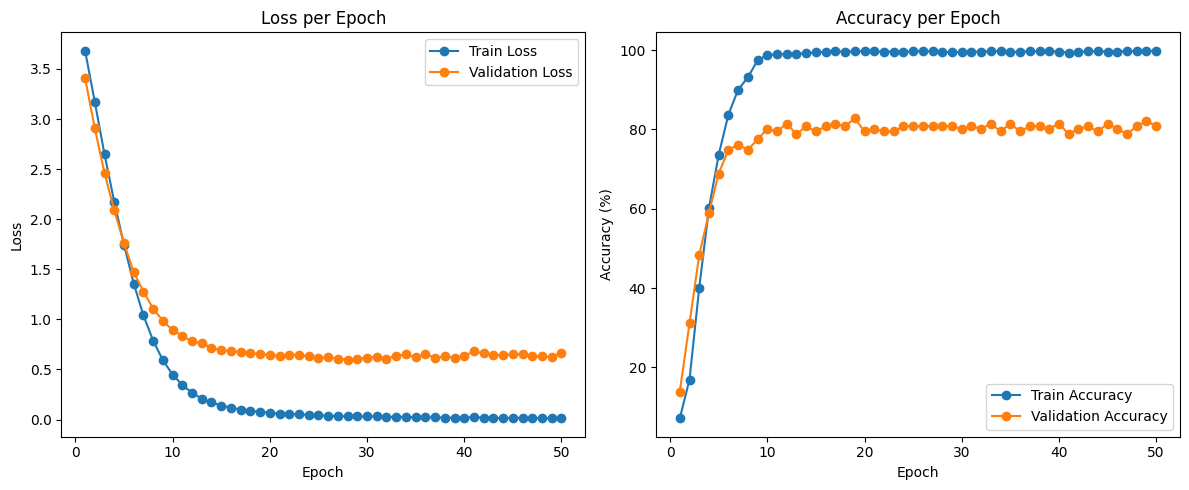

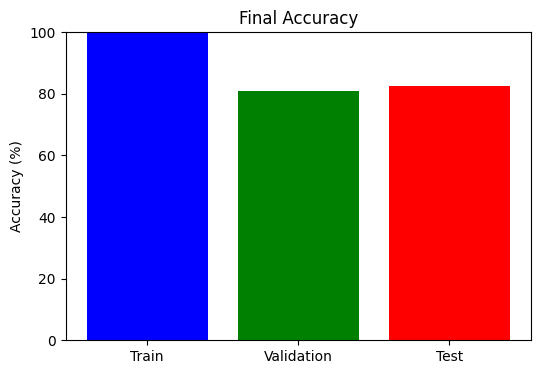

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## Load Raw Features and Labels
X_raw = np.load('X_features.npy')
y = np.load('y_labels.npy')        # Class labels

## Feature Selection (Variance Threshold) — From Scratch
def variance_threshold_selector(X, threshold=0.01):
    variances = np.var(X, axis=0)
    selected_indices = np.where(variances > threshold)[0]
    return X[:, selected_indices], selected_indices

X_selected, selected_indices = variance_threshold_selector(X_raw, threshold=0.01)

## Train-Test-Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

## Standardize Data
def standardise_data(data, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
    return (data - mean) / std, mean, std

X_train_std, train_mean, train_std = standardise_data(X_train)
X_val_std, _, _ = standardise_data(X_val, train_mean, train_std)
X_test_std, _, _ = standardise_data(X_test, train_mean, train_std)

## ANN Architecture
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return self.fc3(x)

## Convert to Tensors and Dataloaders
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

## Initialize Model, Loss, Optimizer
input_size = X_train_std.shape[1]
model = ANN(input_size=input_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop
num_epochs = 50
epoch_train_losses, epoch_val_losses = [], []
epoch_train_accs, epoch_val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == batch_y).sum().item()

    train_loss = total_loss / len(train_loader)
    train_acc = total_correct * 100 / len(train_loader.dataset)
    epoch_train_losses.append(train_loss)
    epoch_train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct * 100 / len(val_loader.dataset)
    epoch_val_losses.append(val_loss)
    epoch_val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

## Test Accuracy
model.eval()
test_correct = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
test_acc = test_correct * 100 / len(test_loader.dataset)

print("\nFinal Accuracies:")
print(f"Train Accuracy: {epoch_train_accs[-1]:.2f}%")
print(f"Validation Accuracy: {epoch_val_accs[-1]:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

## Plot Loss and Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_train_losses, label="Train Loss", marker="o")
plt.plot(epochs, epoch_val_losses, label="Validation Loss", marker="o")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_train_accs, label="Train Accuracy", marker="o")
plt.plot(epochs, epoch_val_accs, label="Validation Accuracy", marker="o")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## Final Accuracy Bar
plt.figure(figsize=(6, 4))
plt.bar(["Train", "Validation", "Test"],
        [epoch_train_accs[-1], epoch_val_accs[-1], test_acc],
        color=["blue", "green", "red"])
plt.title("Final Accuracy")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()


In [ ]:
print(f"Original number of features: {X_raw.shape[1]}")
print(f"Number of features selected: {X_selected.shape[1]}")


Original number of features: 4000
Number of features selected: 4000


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data
X_raw = np.load('X_features.npy')
y = np.load('y_labels.npy')

# Standardization Function
def standardise_data(data, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
    return (data - mean) / std, mean, std

# ANN Model
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return self.fc3(x)

# Training Function
def train_model(X_selected, y, num_epochs=30, batch_size=32):
    X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

    X_train_std, mean, std = standardise_data(X_train)
    X_val_std, _, _ = standardise_data(X_val, mean, std)
    X_test_std, _, _ = standardise_data(X_test, mean, std)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train_std, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)

    test_loader = DataLoader(TensorDataset(torch.tensor(X_test_std, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.long)),
                             batch_size=batch_size, shuffle=False)

    model = ANN(input_size=X_selected.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()

    test_acc = 100 * test_correct / len(test_loader.dataset)
    return test_acc

# Try different thresholds
thresholds = [0.0, 0.001, 0.005, 0.01, 0.02, 0.05]
num_features = []
test_accuracies = []

for thresh in thresholds:
    variances = np.var(X_raw, axis=0)
    selected_indices = np.where(variances > thresh)[0]
    X_selected = X_raw[:, selected_indices]
    print(f"Threshold = {thresh:.3f} -> Features = {X_selected.shape[1]}")

    acc = train_model(X_selected, y)
    print(f"Test Accuracy = {acc:.2f}%\n")

    num_features.append(X_selected.shape[1])
    test_accuracies.append(acc)



Threshold = 0.000 -> Features = 4000
Test Accuracy = 83.08%

Threshold = 0.001 -> Features = 4000
Test Accuracy = 82.92%

Threshold = 0.005 -> Features = 4000
Test Accuracy = 83.42%

Threshold = 0.010 -> Features = 4000
Test Accuracy = 81.92%

Threshold = 0.020 -> Features = 4000
Test Accuracy = 83.58%

Threshold = 0.050 -> Features = 4000
Test Accuracy = 82.42%



Top 50 features selected
Test Accuracy: 8.79%

Top 100 features selected
Test Accuracy: 12.11%

Top 200 features selected
Test Accuracy: 17.08%

Top 300 features selected
Test Accuracy: 27.86%

Top 400 features selected
Test Accuracy: 38.31%

Top 500 features selected
Test Accuracy: 39.14%



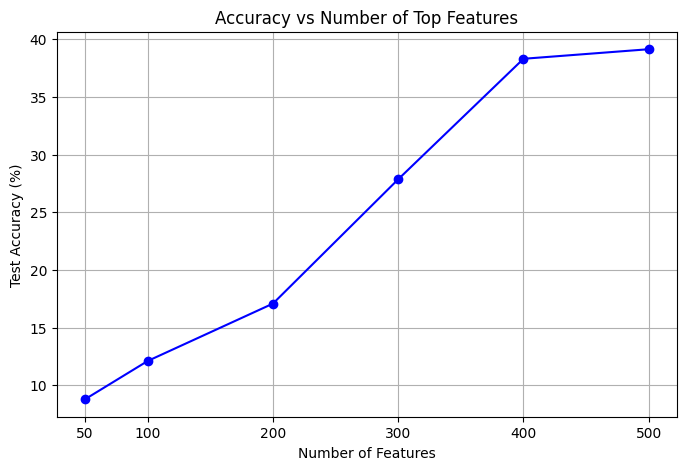

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
X_raw = np.load('X_features.npy')
y = np.load('y_labels.npy')

# Standardization
def standardise_data(data, mean=None, std=None):
    if mean is None or std is None:
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
    return (data - mean) / std, mean, std

# ANN Model
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=50):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return self.fc3(x)

# Train Function
def train_model(X_selected, y, num_epochs=30, batch_size=32):
    X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

    X_train_std, mean, std = standardise_data(X_train)
    X_val_std, _, _ = standardise_data(X_val, mean, std)
    X_test_std, _, _ = standardise_data(X_test, mean, std)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train_std, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)

    test_loader = DataLoader(TensorDataset(torch.tensor(X_test_std, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.long)),
                             batch_size=batch_size, shuffle=False)

    model = ANN(input_size=X_selected.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    test_correct = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()

    test_acc = 100 * test_correct / len(test_loader.dataset)
    return test_acc

# ---- Select Features Based on Variance ----
variances = np.var(X_raw, axis=0)
sorted_indices = np.argsort(-variances)  # Descending order

# Try different numbers of features
feature_counts = [50, 100, 200, 300, 400, 500]
test_accuracies = []

for k in feature_counts:
    top_k_indices = sorted_indices[:k]
    X_selected = X_raw[:, top_k_indices]
    print(f"Top {k} features selected")

    acc = train_model(X_selected, y)
    print(f"Test Accuracy: {acc:.2f}%\n")
    test_accuracies.append(acc)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, test_accuracies, marker='o', color='blue')
plt.title("Accuracy vs Number of Top Features")
plt.xlabel("Number of Features")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.xticks(feature_counts)
plt.show()


In [ ]:
# Updated train_model to return train/val/test accuracies
def train_model(X_selected, y, num_epochs=30, batch_size=32):
    X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, stratify=y, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

    X_train_std, mean, std = standardise_data(X_train)
    X_val_std, _, _ = standardise_data(X_val, mean, std)
    X_test_std, _, _ = standardise_data(X_test, mean, std)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train_std, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val_std, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.long)),
                            batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test_std, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.long)),
                             batch_size=batch_size, shuffle=False)

    model = ANN(input_size=X_selected.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    def evaluate(loader):
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        return 100 * correct / len(loader.dataset)

    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    test_acc = evaluate(test_loader)

    return train_acc, val_acc, test_acc


Training on Top 50 features...
Train: 14.97%, Val: 9.93%, Test: 10.45%

Training on Top 100 features...
Train: 21.68%, Val: 12.58%, Test: 12.94%

Training on Top 200 features...
Train: 36.65%, Val: 16.56%, Test: 18.57%

Training on Top 300 features...
Train: 56.97%, Val: 24.50%, Test: 28.19%

Training on Top 400 features...
Train: 74.79%, Val: 36.42%, Test: 37.65%

Training on Top 500 features...
Train: 86.11%, Val: 43.05%, Test: 39.64%

📊 Best K: 500 | Train: 86.11% | Val: 43.05% | Test: 39.64%


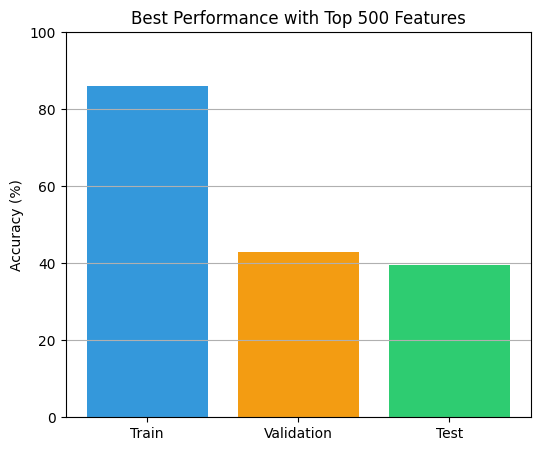

In [ ]:
feature_counts = [50, 100, 200, 300, 400, 500]
results = []

for k in feature_counts:
    top_k_indices = sorted_indices[:k]
    X_selected = X_raw[:, top_k_indices]
    print(f"Training on Top {k} features...")

    train_acc, val_acc, test_acc = train_model(X_selected, y)
    results.append((k, train_acc, val_acc, test_acc))
    print(f"Train: {train_acc:.2f}%, Val: {val_acc:.2f}%, Test: {test_acc:.2f}%\n")

# Find the best result based on highest test accuracy
best_result = max(results, key=lambda x: x[3])
best_k, train_best, val_best, test_best = best_result
print(f"Best K: {best_k} | Train: {train_best:.2f}% | Val: {val_best:.2f}% | Test: {test_best:.2f}%")

# Bar Plot
plt.figure(figsize=(6, 5))
plt.bar(['Train', 'Validation', 'Test'], [train_best, val_best, test_best], color=['#3498db', '#f39c12', '#2ecc71'])
plt.title(f"Best Performance with Top {best_k} Features")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()
